In [1]:
from warnings import filterwarnings
filterwarnings('ignore')
import numpy as np
import pandas as pd
import os
import json

# Web Virtual Beach 
## conceptual demonstration
### building and validating predictive models
### small datasets

In [2]:
kwargs=dict(
    shuffle=True,
    drop_duplicates='Xy',#'X',False
    nan_threshold=0.9,#drop any column with more than this share of nulls
    run_stacked=True, 
    test_share=0,
    cv_folds=5,
    cv_reps=10,
    cv_strategy=None,
    )

from vb_helper import VBHelper
vbhelper=VBHelper(**kwargs)

no daal4py


In [3]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #strings defined in scikit-learn
vbhelper.scorer_list=scorer_list

In [4]:
#load data
data_path=os.path.join('sample_data','ex1.csv')
df=pd.read_csv(data_path)

#select variables
y_name='THG_Fish'
loc_vars=['LAT','LONG']
drop_vars=['Date','OrigHabCode','STA_ID']
drop_vars.extend(loc_vars)
drop_vars.append(y_name)
all_vars=list(df.columns)
x_vars=[var for var in all_vars if var not in drop_vars]

#extract random rows for prediction
predict_n=3
shuf=np.arange(df.shape[0])
seed=0
rng = np.random.default_rng(seed)
rng.shuffle(shuf)
predict_select=shuf[:predict_n]
X_predict=df.loc[:,x_vars].iloc[predict_select].copy()
y_predict=df.loc[:,y_name].iloc[predict_select].copy()
df.drop(index=predict_select,inplace=True)
X_df=df.loc[:,x_vars]
y_df=df.loc[:,[y_name]]


# VB web
### load a dataset
dimensions of X:

In [5]:
X_df.shape

(771, 45)

dimensions of y:

In [6]:
y_df.shape

(771, 1)

#### import the data and check for duplicates

In [7]:
vbhelper.setData(X_df,y_df)

# of duplicate rows of data: 0
# of duplicate rows of X: 0
# of duplicate Xy rows dropped: 0
no columns exceeded nan threshold of 0.9


# VB web
### Take a look at the data

#### export the data to json to mimic front-end/back-end network communication

In [8]:
vbhelper.saveFullFloatXy()
with open('summaryXy.json','r') as f:
    data_for_summary=json.load(f)

In [9]:
from vb_summary import VBSummary
vbs=VBSummary()
vbs.setData(data_for_summary)

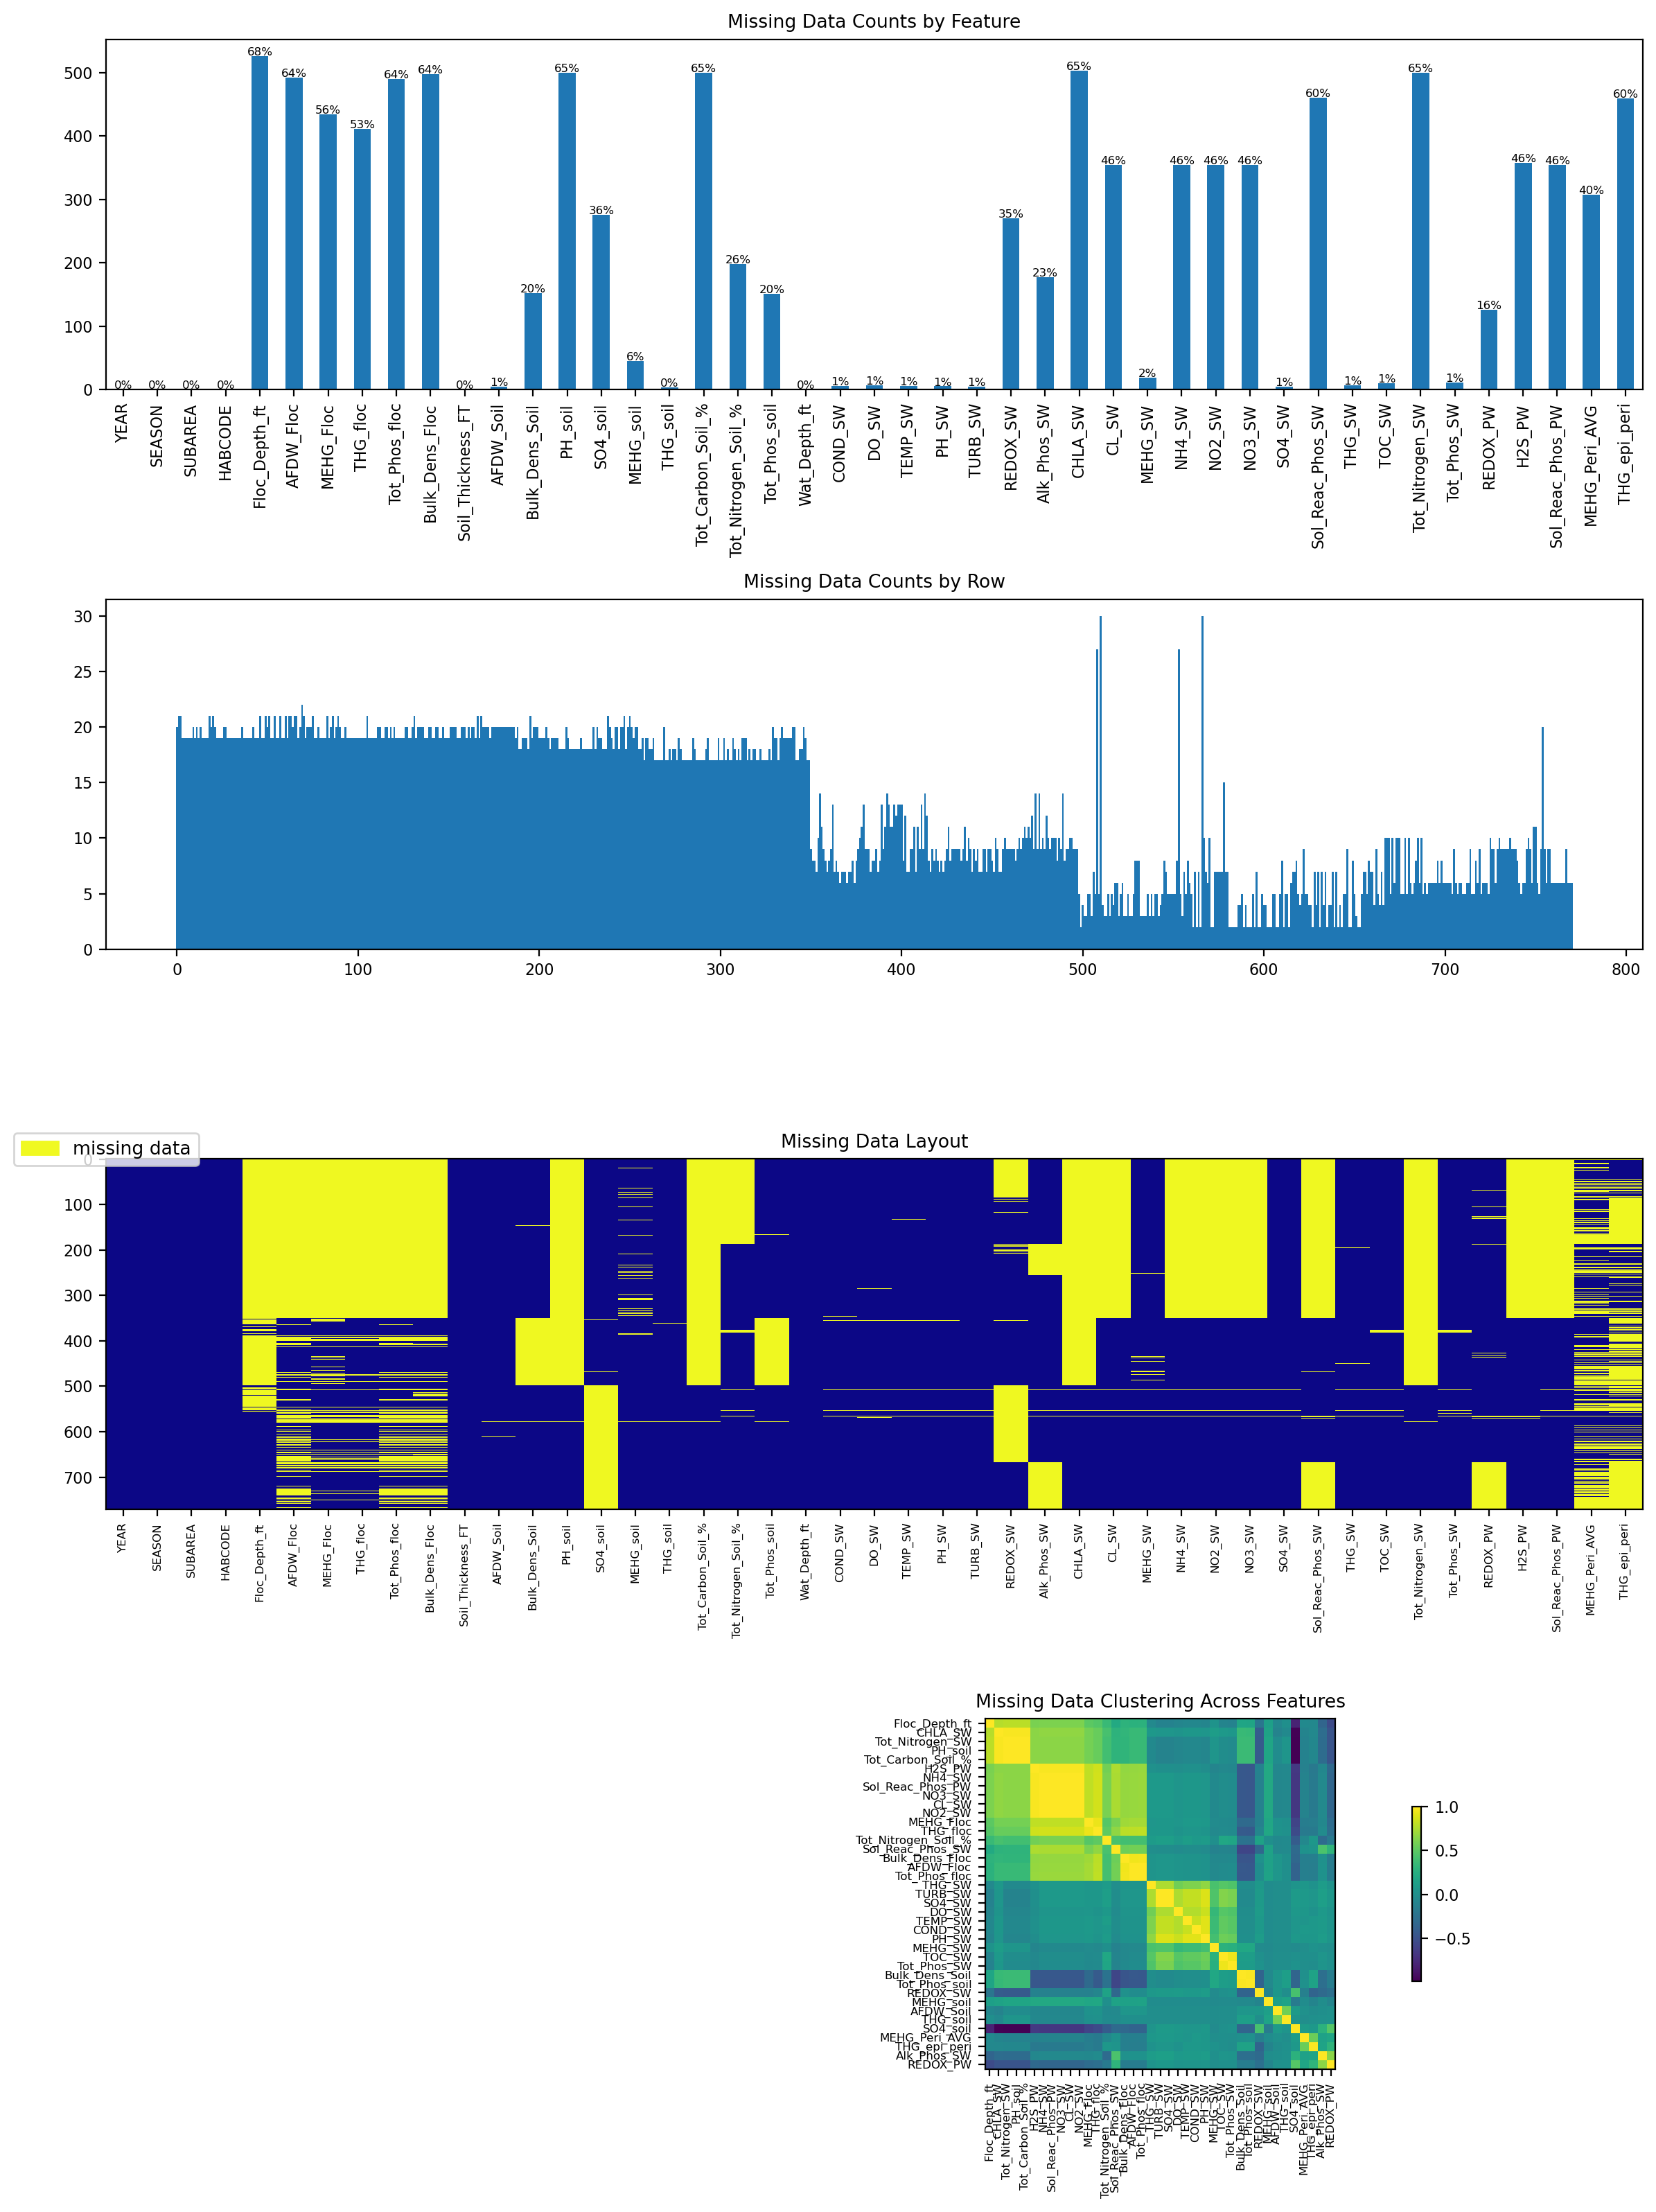

In [10]:
vbs.missingVals()

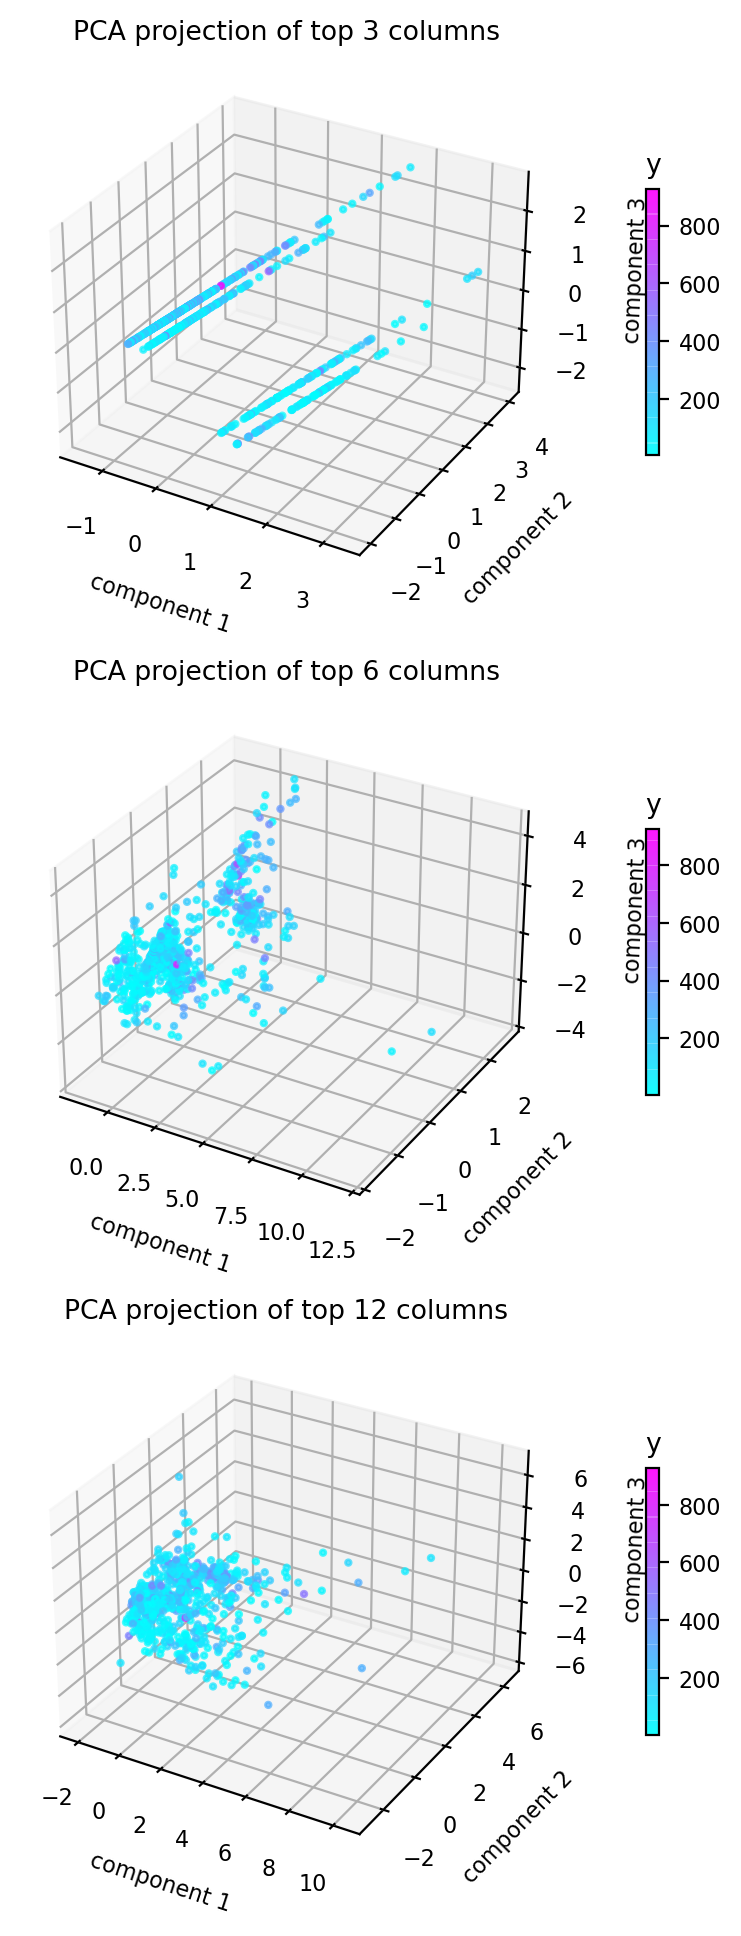

In [11]:
vbs.viewComponents(num_cols=[3,6,12])

In [ ]:
vbs.kernelDensityPie()

In [ ]:
#vbs.hierarchicalDendrogram(linkage='ward',dist='pearsonr')

In [ ]:
vbs.hierarchicalDendrogram(linkage='ward',dist='spearmanr')

# VB web
### Machine Learning Pipelines

#### What is a pipeline?


 - steps
   - setup data preparation
    - one-hot-encoding
    - imputation
   - setup pipeline
    - inner cross-validation
    - feature engineering and estimation

#### specify internal CV for hyper-parameter tuning

In [ ]:
inner_cv_dict={
    'cv_reps':1,
    'cv_folds':5,
    'cv_strategy':('quantile',5)} # ensure each fold has y values from each quantile
inner_cv=vbhelper.getCV(cv_dict=inner_cv_dict)

#### specify data preparation

In [ ]:
prep_dict={
    'cat_approach':'together', # imputation is over all variables after one-hot-encoding
    'impute_strategy':'IterativeImputer', # python implementation of MICE: Multivariate Imputation by Chained Equations in R”
    'cat_idx':vbhelper.cat_idx # keep track of the categorical variables
    }
pipe_dict={} # the pipeline setup will go here

#### specify pipelines

##### setup keyword arguments for pipelines

In [ ]:
pipe_kwargs={
    'do_prep':not vbhelper.run_stacked, # the stacking regressor will do imputation if run_stacked==False
    'prep_dict':prep_dict,
    'inner_cv':inner_cv,
    'cat_idx':vbhelper.cat_idx,
    'float_idx':vbhelper.float_idx,
    'bestT':False # if true, test each covariate for optimal transformation 
    }

##### create a cross-validated lasso linear regression pipeline

In [ ]:
from vb_estimators import  L1Lars

l1_kwargs=pipe_kwargs.copy()
l1_kwargs['max_n_alphas']=500 # alpha is the only hyper-parameter
pipe_dict['lassolars']={
    'pipe':L1Lars,
    'pipe_kwargs':l1_kwargs
    }

##### and a gradient boosting regressor pipeline

In [ ]:
from vb_estimators import GBR

gbr_kwargs=pipe_kwargs.copy()
gbr_kwargs['est_kwargs']={
    'n_estimators':[64,128],
    'max_depth':[2,3]
    }
pipe_dict['gbr']={
    'pipe':GBR,
    'pipe_kwargs':gbr_kwargs
    }

##### and a gradient boosting regressor pipeline

In [ ]:
from vb_estimators import RBFSVR

rbf_kwargs=pipe_kwargs.copy()
rbf_kwargs['gridpoints']=5 
pipe_dict['rbfSVR']={
    'pipe':RBFSVR,
    'pipe_kwargs':rbf_kwargs
    }

and finally add a pipeline that tests a few non-linear models

In [ ]:
from vb_estimators import FlexiblePipe

nl_pipe_kwargs=pipe_kwargs.copy()
nl_pipe_kwargs['functional_form_search']=True
nl_pipe_kwargs['flex_kwargs']={'robust':True}
pipe_dict['nonlinear']={
    'pipe':FlexiblePipe,
    'pipe_kwargs':nl_pipe_kwargs
}

In [ ]:
#and load the pipelines
vbhelper.setPipeDict(pipe_dict)
vbhelper.setModelDict()

In [ ]:
from sklearn.model_selection import train_test_split
from time import time
X_train, X_test, y_train, y_test=train_test_split(X_df,y_df,test_size=0.7,random_state=5) #just for debugging

In [ ]:
runtest=False
if runtest:
    for name,est in vbhelper.model_dict.items():
        start=time()
        print(name)
        est.fit(X_train,y_train)
        print('train R2:',est.score(X_train,y_train))
        if not X_test is None:print('test R2:',est.score(X_test,y_test))
        end=time()
        print(f'runtime:{(end-start)/60} min.\n')

In [ ]:
if vbhelper.run_stacked and runtest:
    mp=vbhelper.model_dict['multi_pipe']
    fitted_ipipe_dict=mp.build_individual_fitted_pipelines()
    for p_name,p in fitted_ipipe_dict.items():
        print(f'{p_name} scored: {p.score(X_test,y_test)}')


# VB web
### run the cross validation experiment

In [ ]:
vbhelper.runCrossValidate(try_load=True)

In [ ]:
vbhelper.buildCVScoreDict()
vbhelper.saveCVResults()

### Plot the results

In [ ]:
with open('project_cv_results.json','rb') as f:
    cv_results_and_scores=json.load(f)
    
from vb_plotter import VBPlotter
plotter=VBPlotter()
plotter.setData(cv_results_and_scores)

In [ ]:
plotter.plotCVYhatVsY(single_plot=True,include_all_cv=True)

In [ ]:
plotter.plotCVYhat(single_plot=True,include_all_cv=True) #add option to use original row order instead of sort

In [ ]:
plotter.plotCVScores(sort=1)

In [ ]:
plotter.plotBoxWhiskerCVScores()

# VB web
### The Stacking Regressor is selected

In [ ]:
vbhelper.refitPredictiveModels(selected_models=['stacking_reg'])

### Prediction
Finally we are ready to use the predictive model that we just estimated.


In [ ]:
vbhelper.predictandSave(X_predict)

In [ ]:
#mimicking the front end-back end data transfer...
with open('project_prediction_results.json', 'r') as f:
    project_prediction_results=json.load(f)
plotter.setPredictData(project_prediction_results)

#### plot the predicted values along with the training data

In [ ]:
plotter.plotCVYhatVsY(single_plot=True, include_all_cv=True,ypredict=True,cv_ypredict=True,estimators='selected')

#### And we can now see the true values of y as vertical lines

In [ ]:
plotter.plotCVYhatVsY(single_plot=True, include_all_cv=True,ypredict=True,cv_ypredict=True,estimators='selected',true_y=y_predict)